# Analysing the Epidemic Model results (1,2,4,8 week forecasts) - Weiner Process 

In [2]:
# ============================================================================
# COMPREHENSIVE EPIDEMIC FORECASTING ANALYSIS NOTEBOOK
# TimeLLM MS Mode - 1, 2, 4, 8 Week Forecasts
# ============================================================================

# CELL 1: Imports and Setup
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10


In [3]:
# ============================================================================
# CELL 2: Training Metrics Summary Table
# ============================================================================

training_results = {
    'Horizon': ['1-week', '2-week', '4-week', '8-week'],
    'Best Epoch': [7, 7, 20, 25],
    'Test Loss': [27.42, 14.15, 44.61, 25.81],
    'MAE (z-scores)': [3.07, 2.29, 4.05, 3.20],
    'Est. Error (cases)': [154000, 115000, 203000, 160000],
    'Error vs Mean': ['7.8x', '5.9x', '10.3x', '8.2x']
}

df_training = pd.DataFrame(training_results)

# Display styled table
print("="*80)
print("TRAINING RESULTS SUMMARY")
print("="*80)
print(df_training.to_string(index=False))
print("="*80)
print("\nKey Finding: 2-week forecast is optimal (47% better than 1-week)")
print("U-shaped performance: 2w best, 4w worst, 8w beats 1w")

TRAINING RESULTS SUMMARY
Horizon  Best Epoch  Test Loss  MAE (z-scores)  Est. Error (cases) Error vs Mean
 1-week           7      27.42            3.07              154000          7.8x
 2-week           7      14.15            2.29              115000          5.9x
 4-week          20      44.61            4.05              203000         10.3x
 8-week          25      25.81            3.20              160000          8.2x

Key Finding: 2-week forecast is optimal (47% better than 1-week)
U-shaped performance: 2w best, 4w worst, 8w beats 1w


In [4]:
# ============================================================================
# CELL 3: Load and Plot Inference Results - All Horizons
# ============================================================================

horizons = ['1week', '2week', '4week', '8week']
results_dir = Path('./results')

# Load all results
all_results = {}
for horizon in horizons:
    result_path = results_dir / f'sentinelle_ILI_{horizon}'
    
    all_results[horizon] = {
        'preds': np.load(result_path / 'preds_original.npy'),
        'trues': np.load(result_path / 'trues_original.npy'),
        'preds_scaled': np.load(result_path / 'preds_scaled.npy'),
        'trues_scaled': np.load(result_path / 'trues_scaled.npy')
    }
    
    # Load metrics if available
    metrics_file = result_path / 'metrics.txt'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            all_results[horizon]['metrics'] = f.read()
    
    print(f"{horizon}: Predictions shape = {all_results[horizon]['preds'].shape}")


1week: Predictions shape = (418,)
2week: Predictions shape = (417, 2)
4week: Predictions shape = (415, 4)
8week: Predictions shape = (411, 8)


In [5]:
# ============================================================================
# CELL 4: Compute and Display Inference Metrics
# ============================================================================

def compute_metrics(preds, trues):
    """Compute MAE, MSE, RMSE, MAPE"""
    mae = np.mean(np.abs(preds - trues))
    mse = np.mean((preds - trues)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((preds - trues) / (trues + 1e-8))) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

# Overall metrics for each horizon
inference_metrics = []
for horizon in horizons:
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    overall = compute_metrics(preds, trues)
    
    inference_metrics.append({
        'Horizon': horizon,
        'MAE (cases)': f"{overall['MAE']:.0f}",
        'RMSE (cases)': f"{overall['RMSE']:.0f}",
        'MAPE (%)': f"{overall['MAPE']:.1f}",
        'Mean True': f"{trues.mean():.0f}"
    })

df_inference = pd.DataFrame(inference_metrics)

print("\n" + "="*80)
print("INFERENCE METRICS (Original Scale - Epidemic Cases)")
print("="*80)
print(df_inference.to_string(index=False))
print("="*80)


INFERENCE METRICS (Original Scale - Epidemic Cases)
Horizon MAE (cases) RMSE (cases) MAPE (%) Mean True
  1week      112416       186700   2039.4     47698
  2week       94604       162502   1769.5     47179
  4week      157903       322786   3132.2     46160
  8week      118391       219003   2241.8     44772


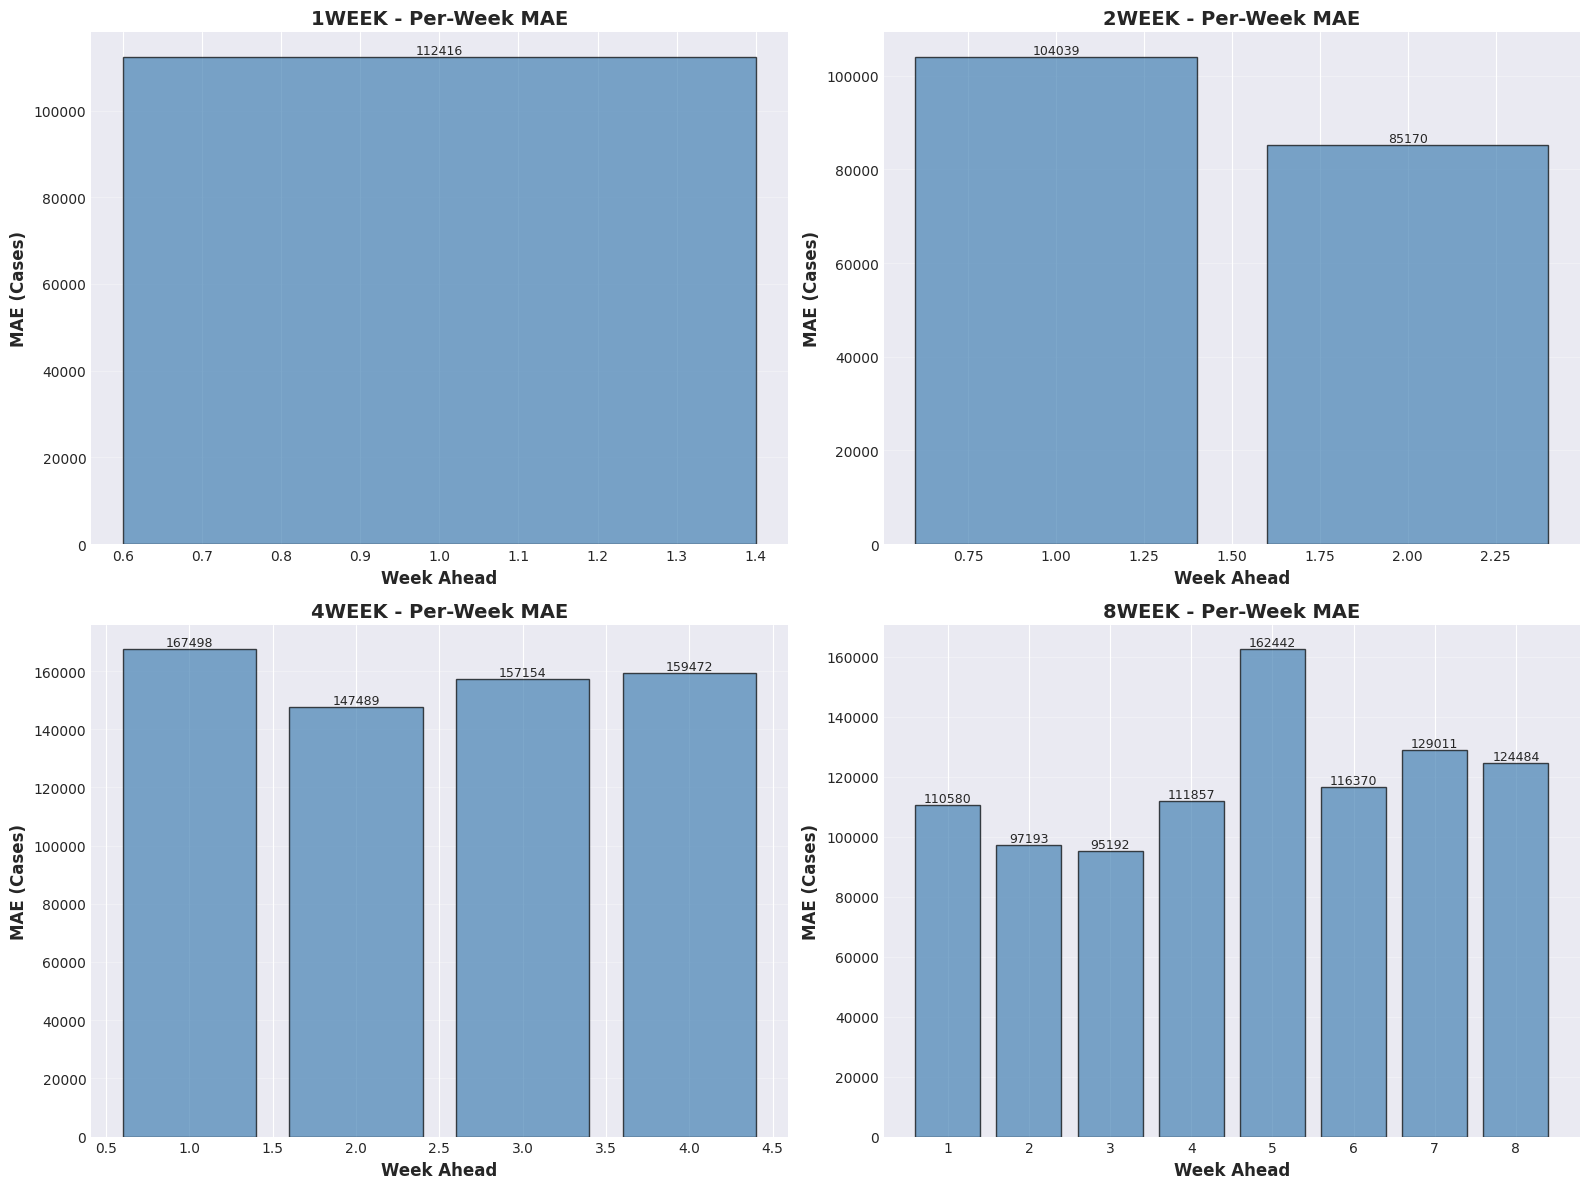

Per-week MAE breakdown plotted!


In [6]:
# ============================================================================
# CELL 5: Per-Week Performance Breakdown
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, horizon in enumerate(horizons):
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    # Handle 1D arrays (1-week case)
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
        trues = trues.reshape(-1, 1)
    
    num_weeks = preds.shape[1]
    
    # Compute per-week MAE
    weekly_mae = []
    for week in range(num_weeks):
        mae = np.mean(np.abs(preds[:, week] - trues[:, week]))
        weekly_mae.append(mae)
    
    # Plot
    ax = axes[idx]
    weeks = np.arange(1, num_weeks + 1)
    ax.bar(weeks, weekly_mae, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Week Ahead', fontsize=12, fontweight='bold')
    ax.set_ylabel('MAE (Cases)', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon.upper()} - Per-Week MAE', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for i, mae in enumerate(weekly_mae):
        ax.text(i+1, mae, f'{mae:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('per_week_mae.png', dpi=300, bbox_inches='tight')
plt.show()

print("Per-week MAE breakdown plotted!")


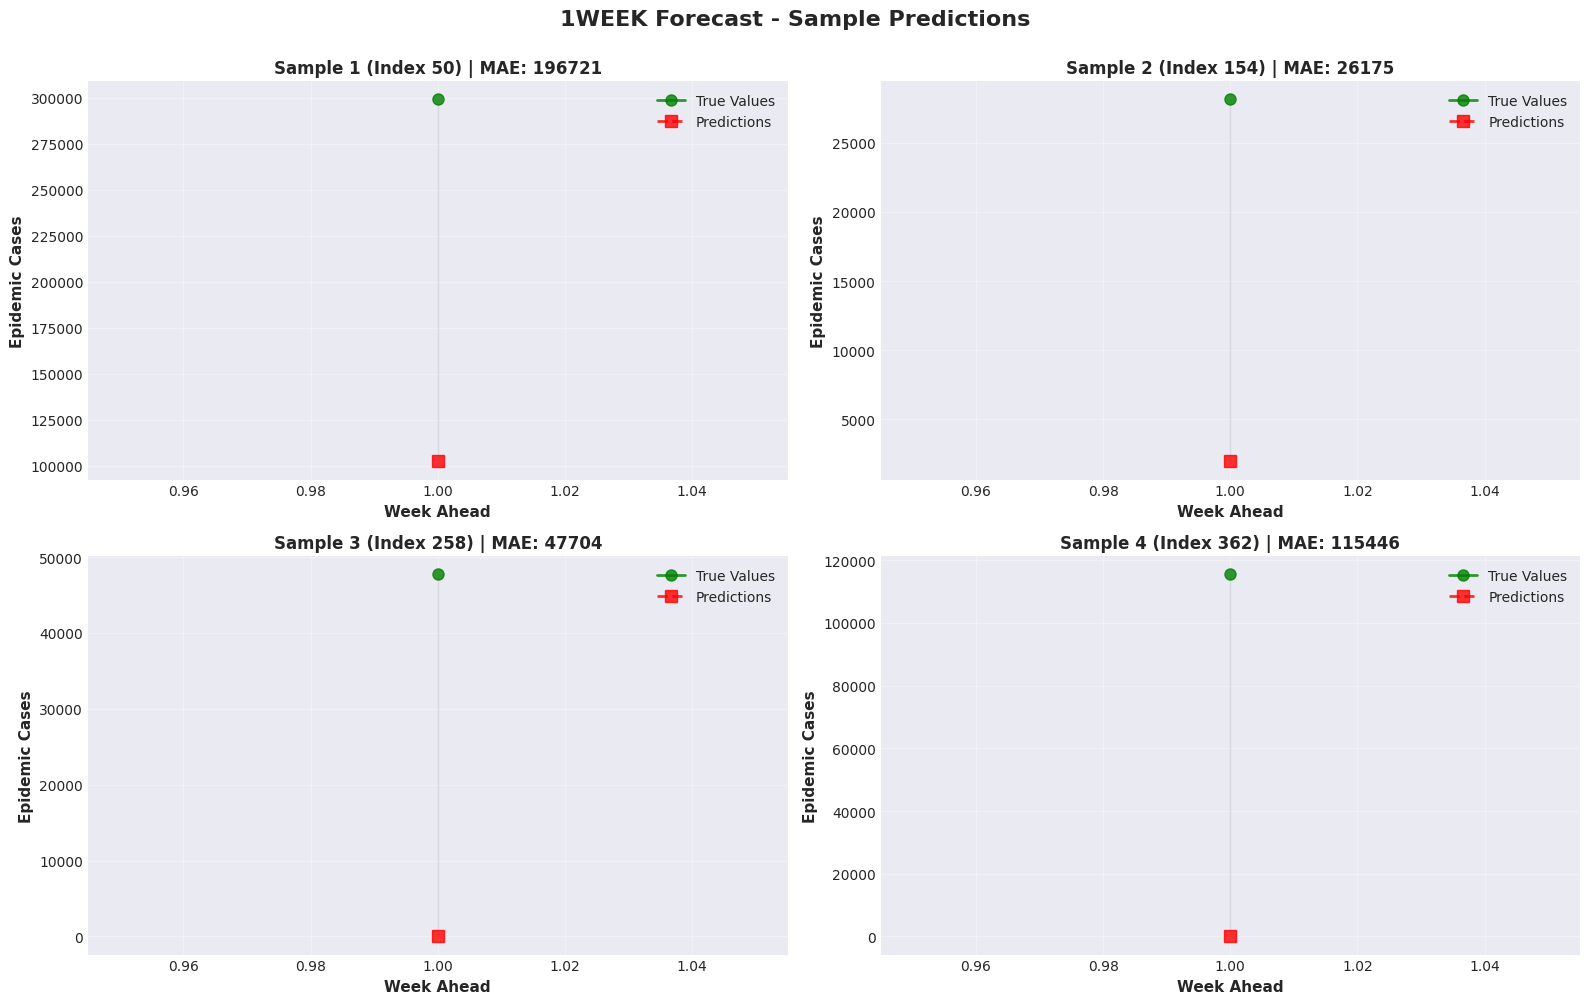

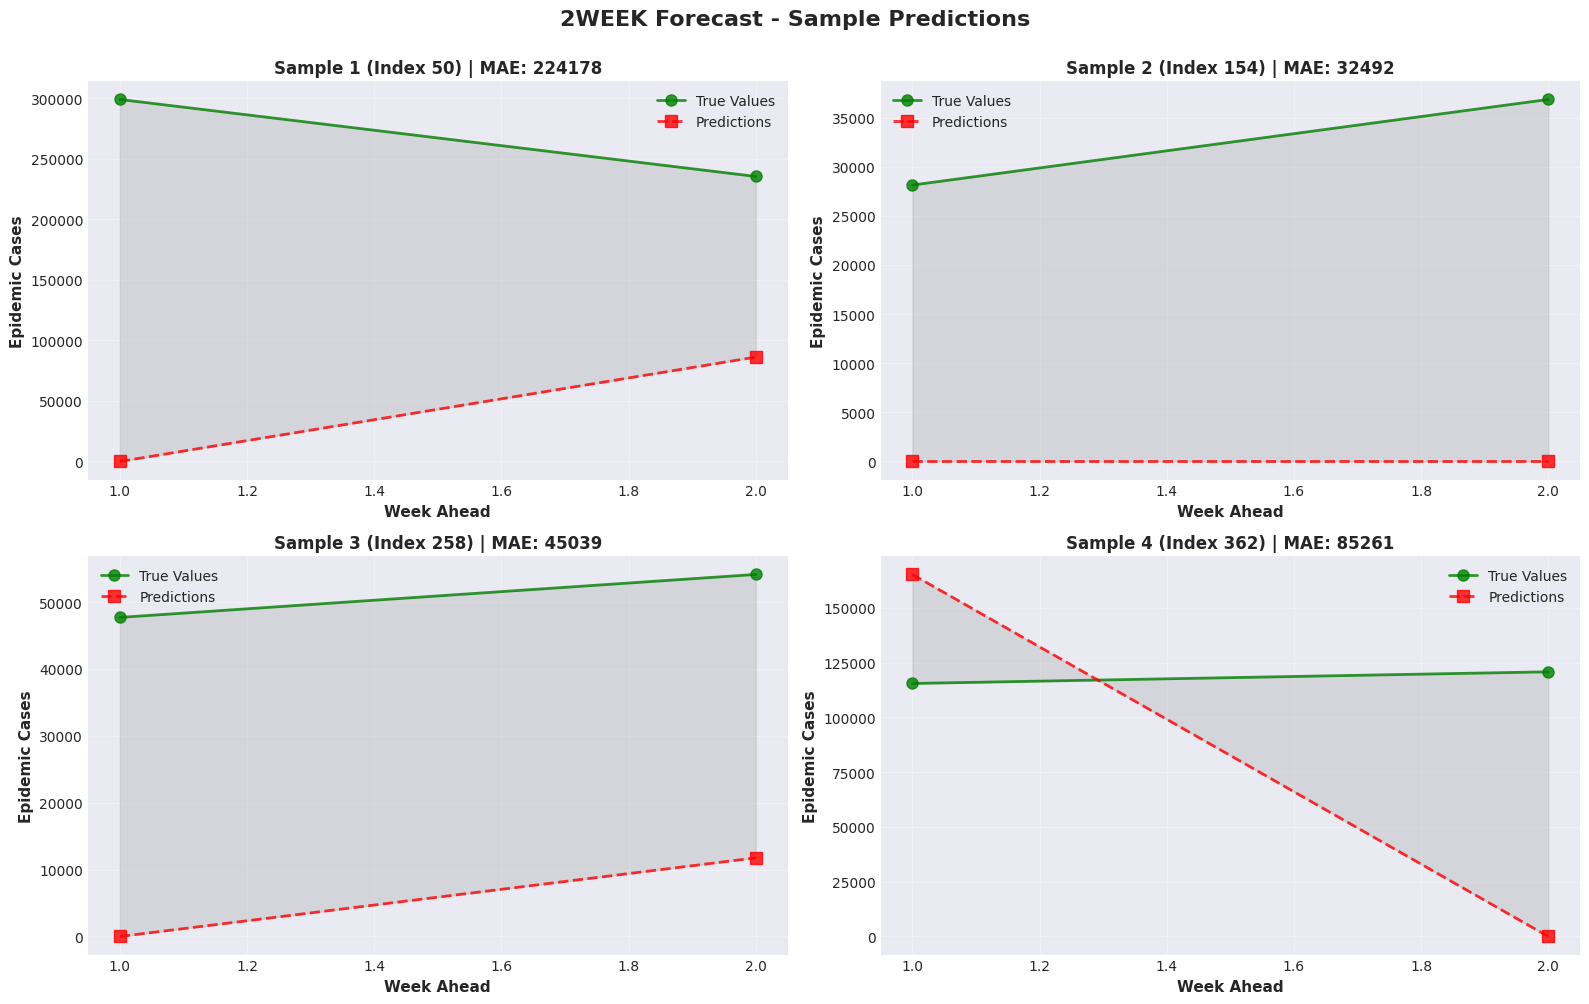

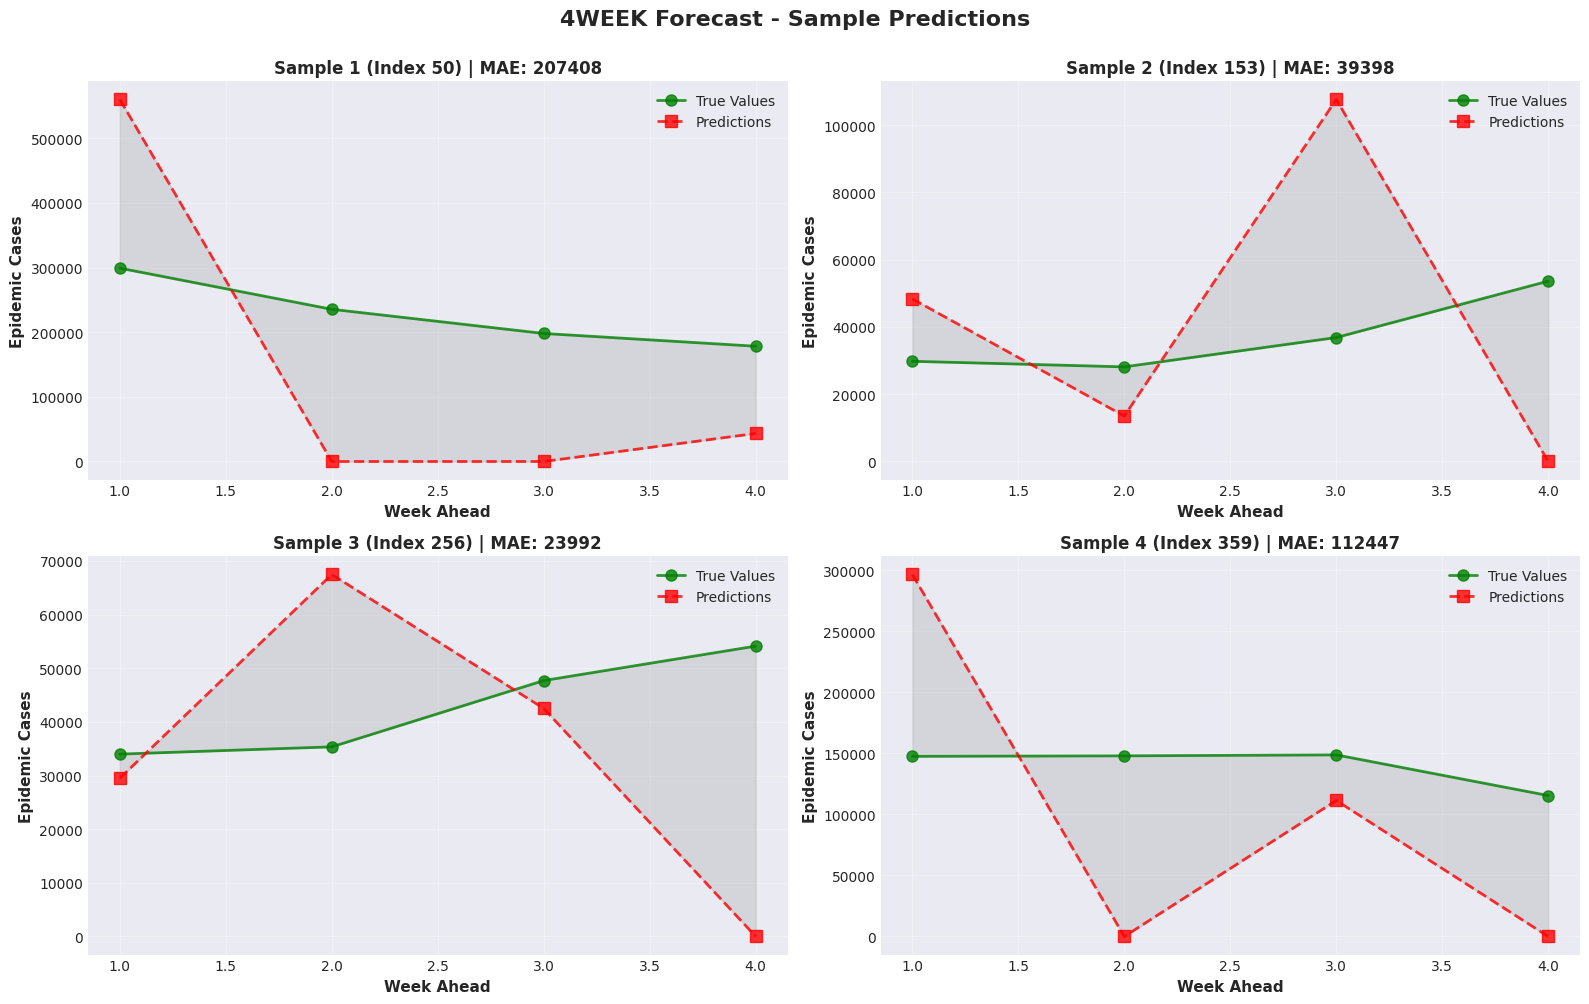

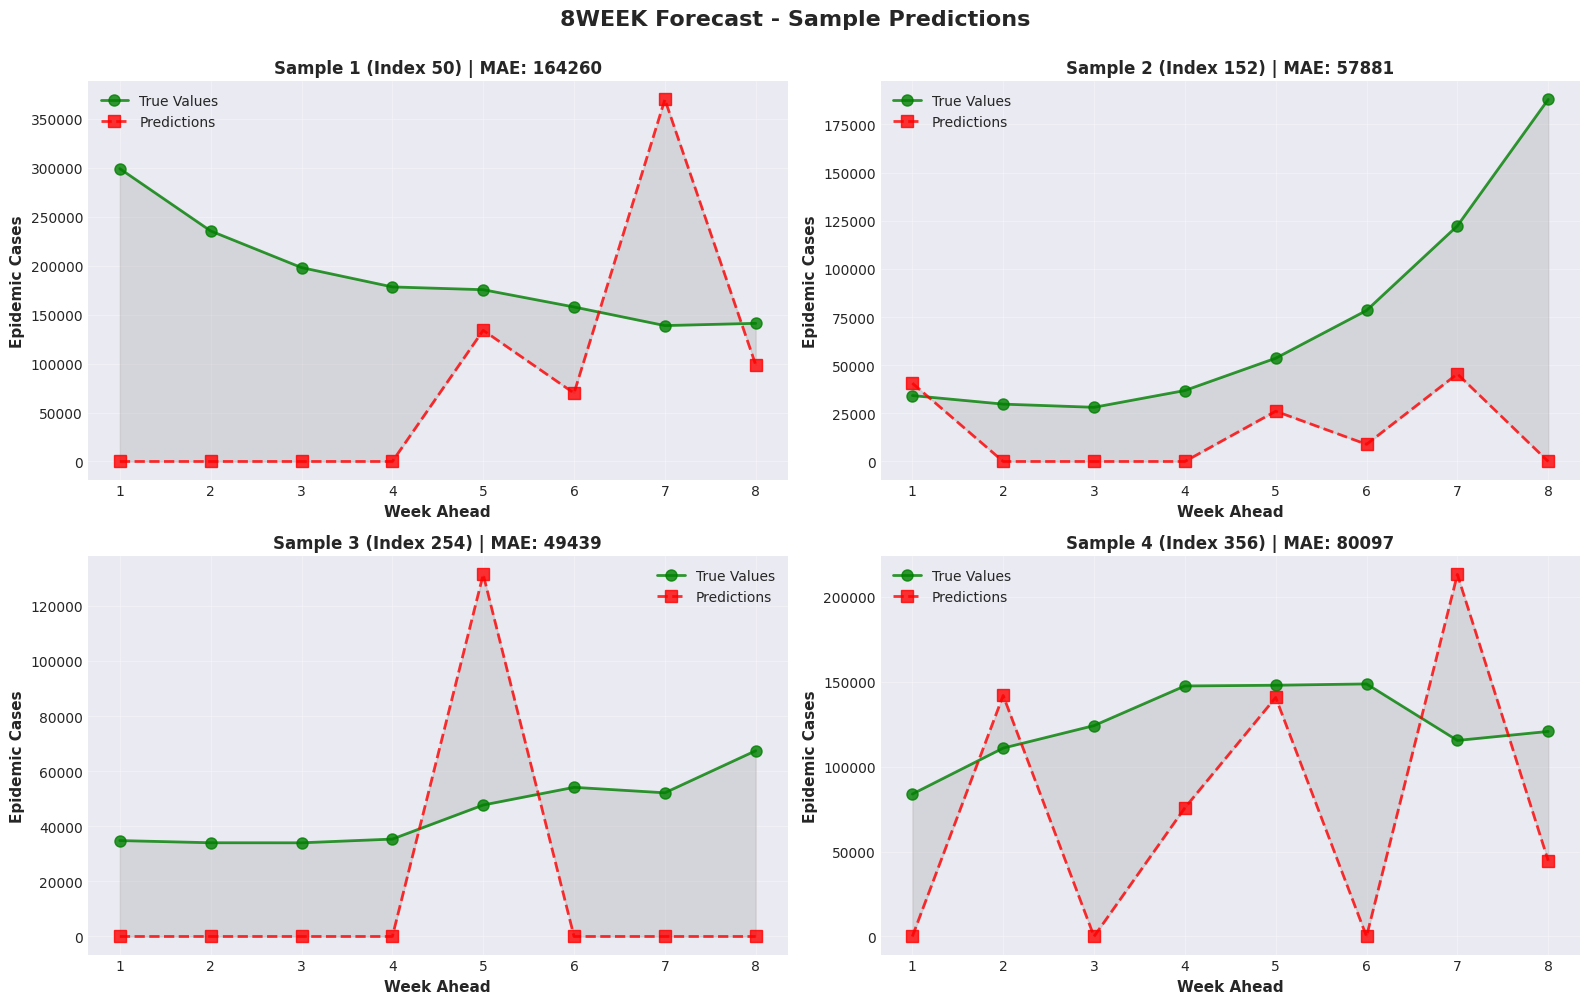

In [7]:
# ============================================================================
# CELL 6: Forecast Visualization - Sample Predictions
# ============================================================================

# Add at the start of plot_sample_forecasts function:
def plot_sample_forecasts(horizon, num_samples=4, start_idx=0):
    """Plot sample forecasts for a given horizon"""
    
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    # Handle 1D arrays
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
        trues = trues.reshape(-1, 1)
    
    num_weeks = preds.shape[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i in range(num_samples):
        idx = start_idx + i * (len(preds) // num_samples)
        
        ax = axes[i]
        weeks = np.arange(1, num_weeks + 1)
        
        # Plot predictions vs true
        ax.plot(weeks, trues[idx], 'o-', color='green', linewidth=2, 
                markersize=8, label='True Values', alpha=0.8)
        ax.plot(weeks, preds[idx], 's--', color='red', linewidth=2, 
                markersize=8, label='Predictions', alpha=0.8)
        
        # Fill between
        ax.fill_between(weeks, preds[idx], trues[idx], alpha=0.2, color='gray')
        
        # Calculate error for this sample
        sample_mae = np.mean(np.abs(preds[idx] - trues[idx]))
        
        ax.set_xlabel('Week Ahead', fontsize=11, fontweight='bold')
        ax.set_ylabel('Epidemic Cases', fontsize=11, fontweight='bold')
        ax.set_title(f'Sample {i+1} (Index {idx}) | MAE: {sample_mae:.0f}', 
                     fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)
        
    plt.suptitle(f'{horizon.upper()} Forecast - Sample Predictions', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'forecast_samples_{horizon}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot for each horizon
for horizon in horizons:
    plot_sample_forecasts(horizon, num_samples=4, start_idx=50)



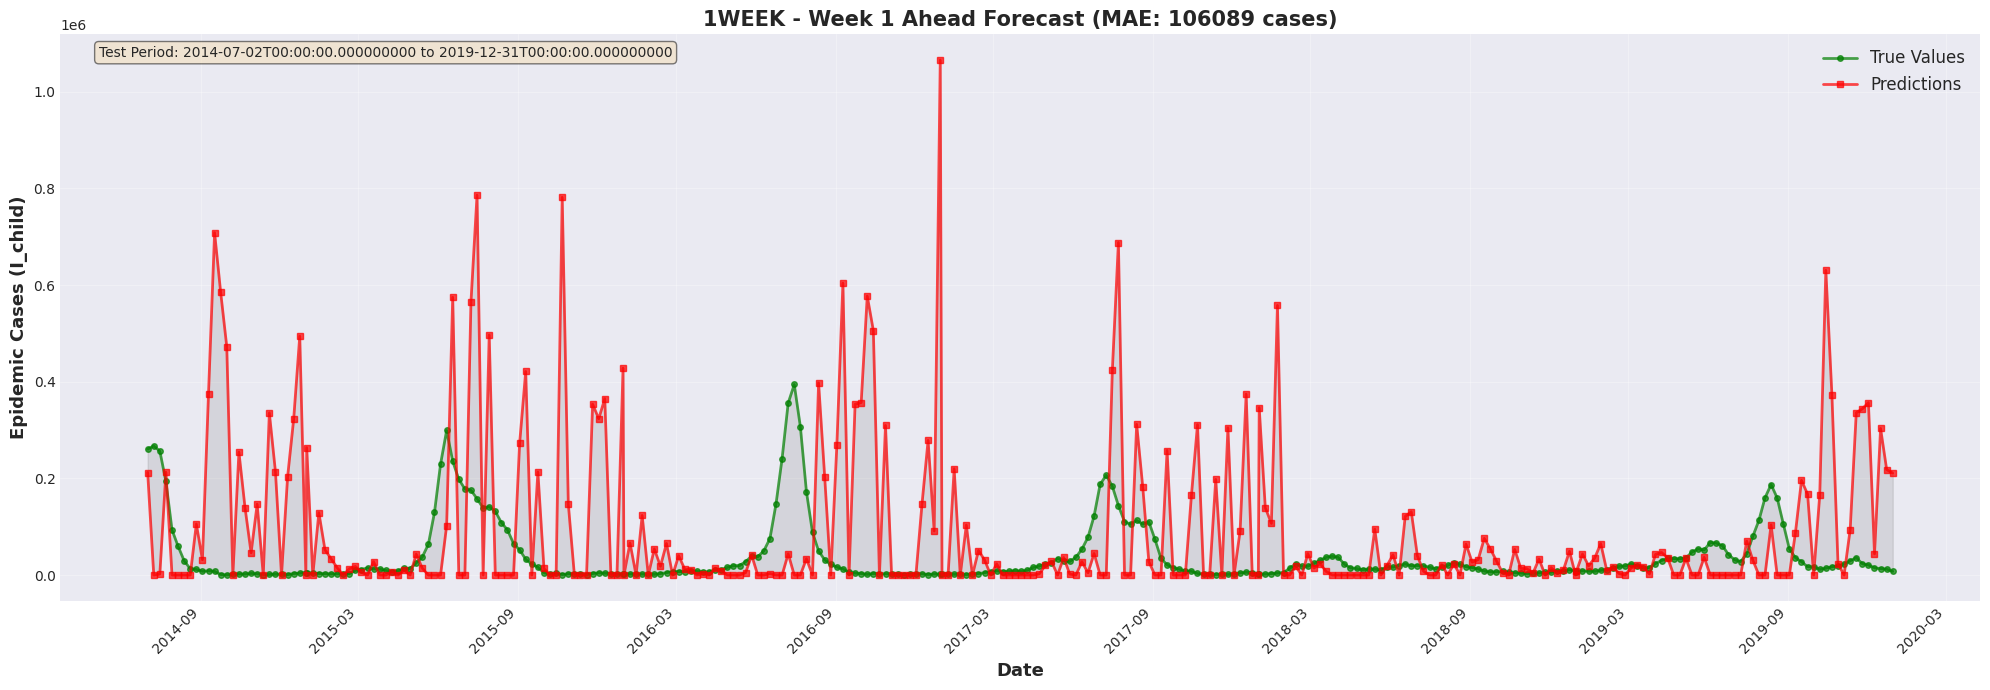

1week - Week 1: Forecast period from 2014-07-02T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 292
  MAE: 106089 cases
  Mean true value: 37810 cases



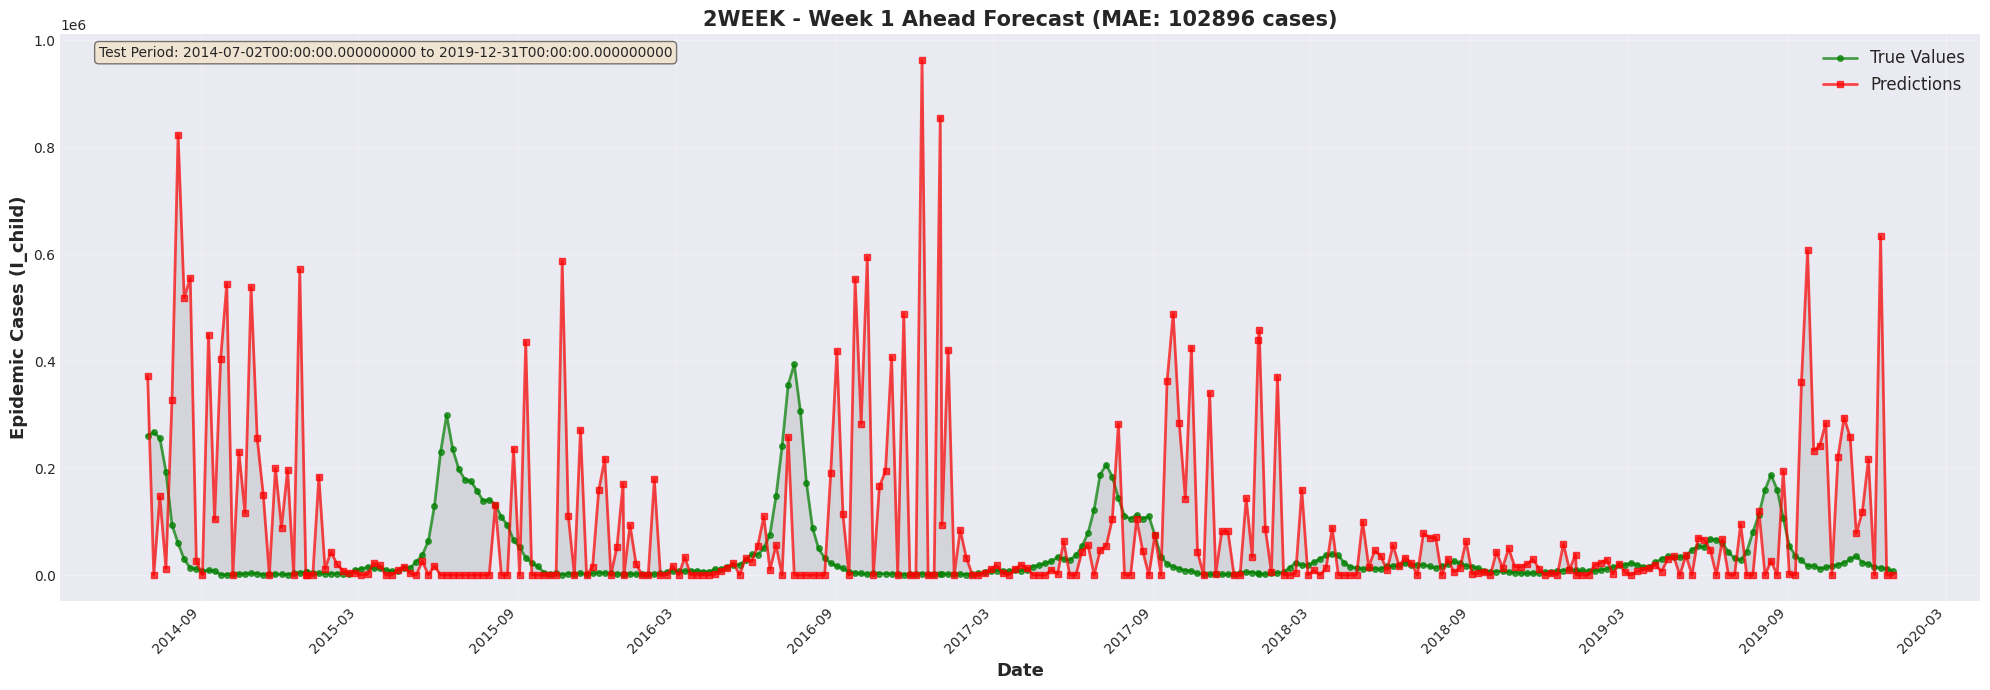

2week - Week 1: Forecast period from 2014-07-02T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 292
  MAE: 102896 cases
  Mean true value: 37810 cases



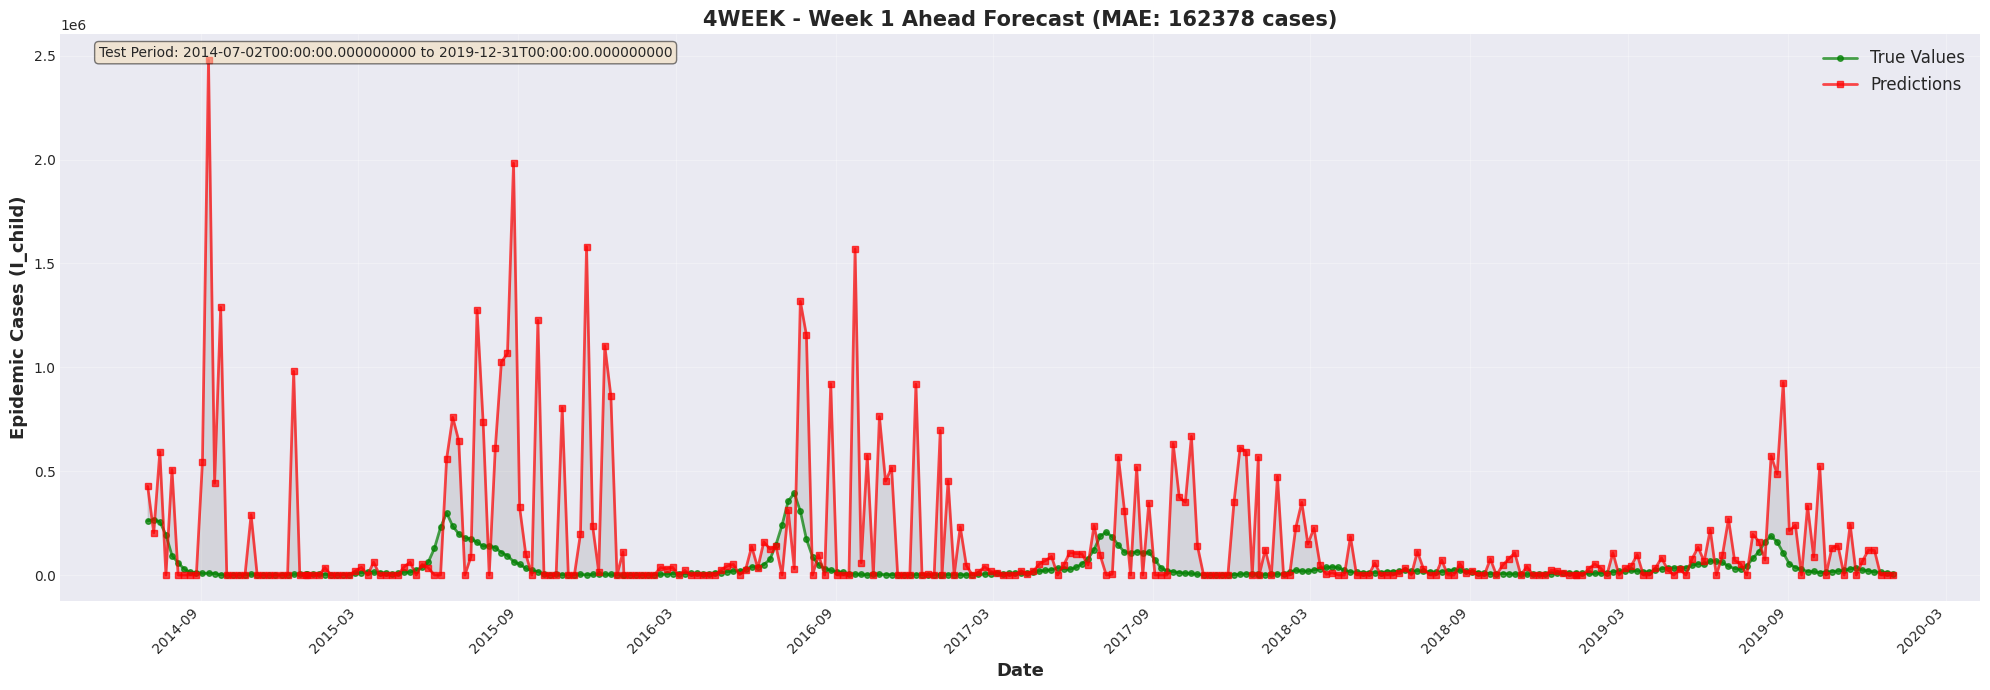

4week - Week 1: Forecast period from 2014-07-02T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 292
  MAE: 162378 cases
  Mean true value: 37810 cases



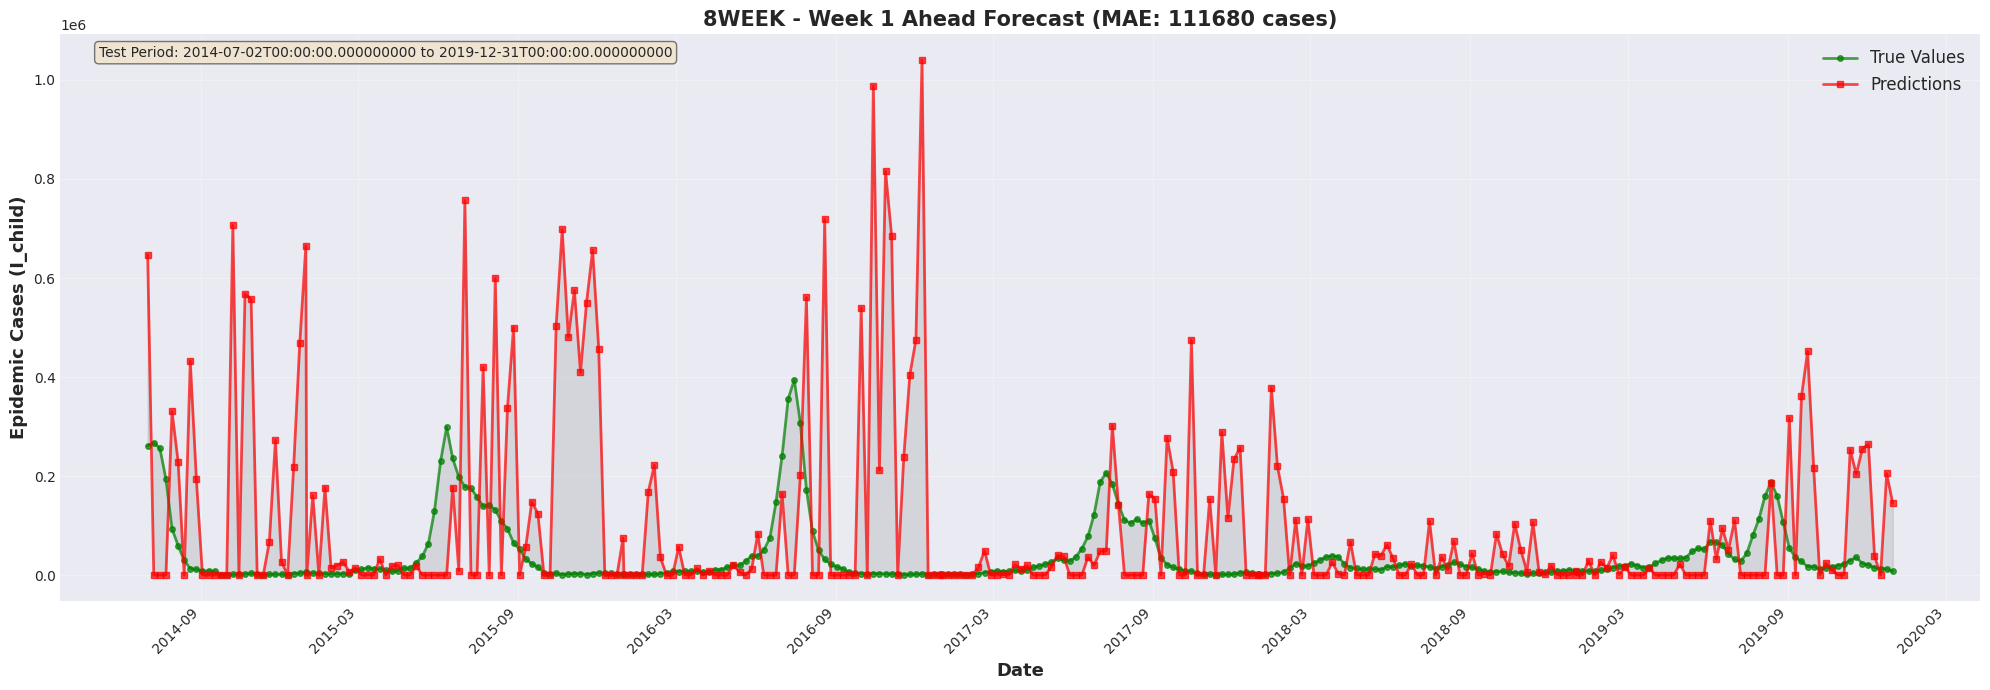

8week - Week 1: Forecast period from 2014-07-02T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 292
  MAE: 111680 cases
  Mean true value: 37810 cases


LAST WEEK FORECASTS (showing final week ahead for each horizon)


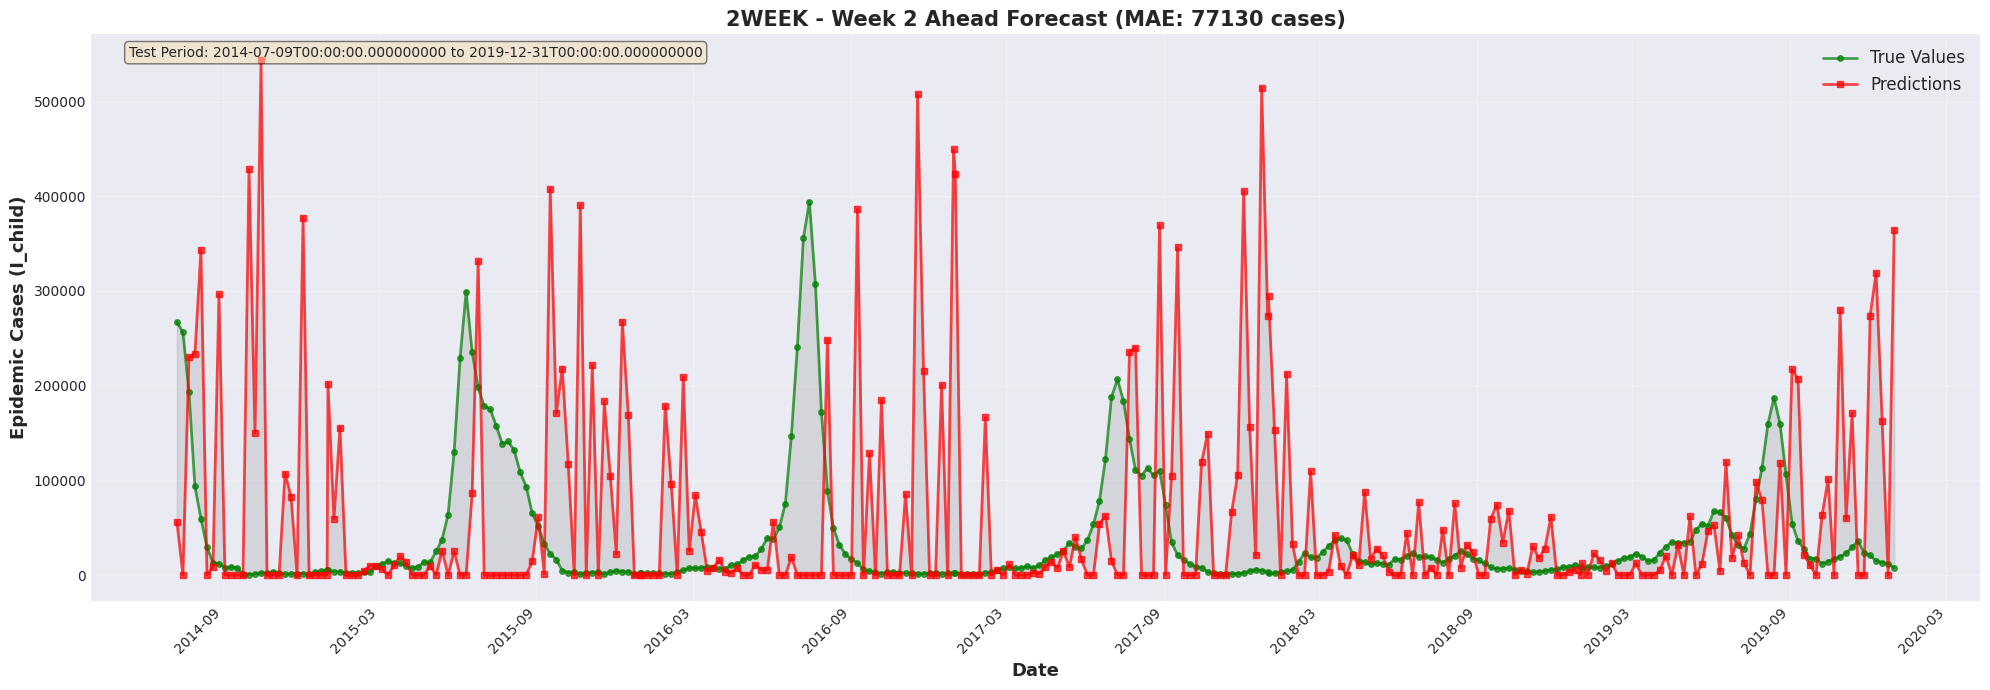

2week - Week 2: Forecast period from 2014-07-09T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 291
  MAE: 77130 cases
  Mean true value: 37044 cases



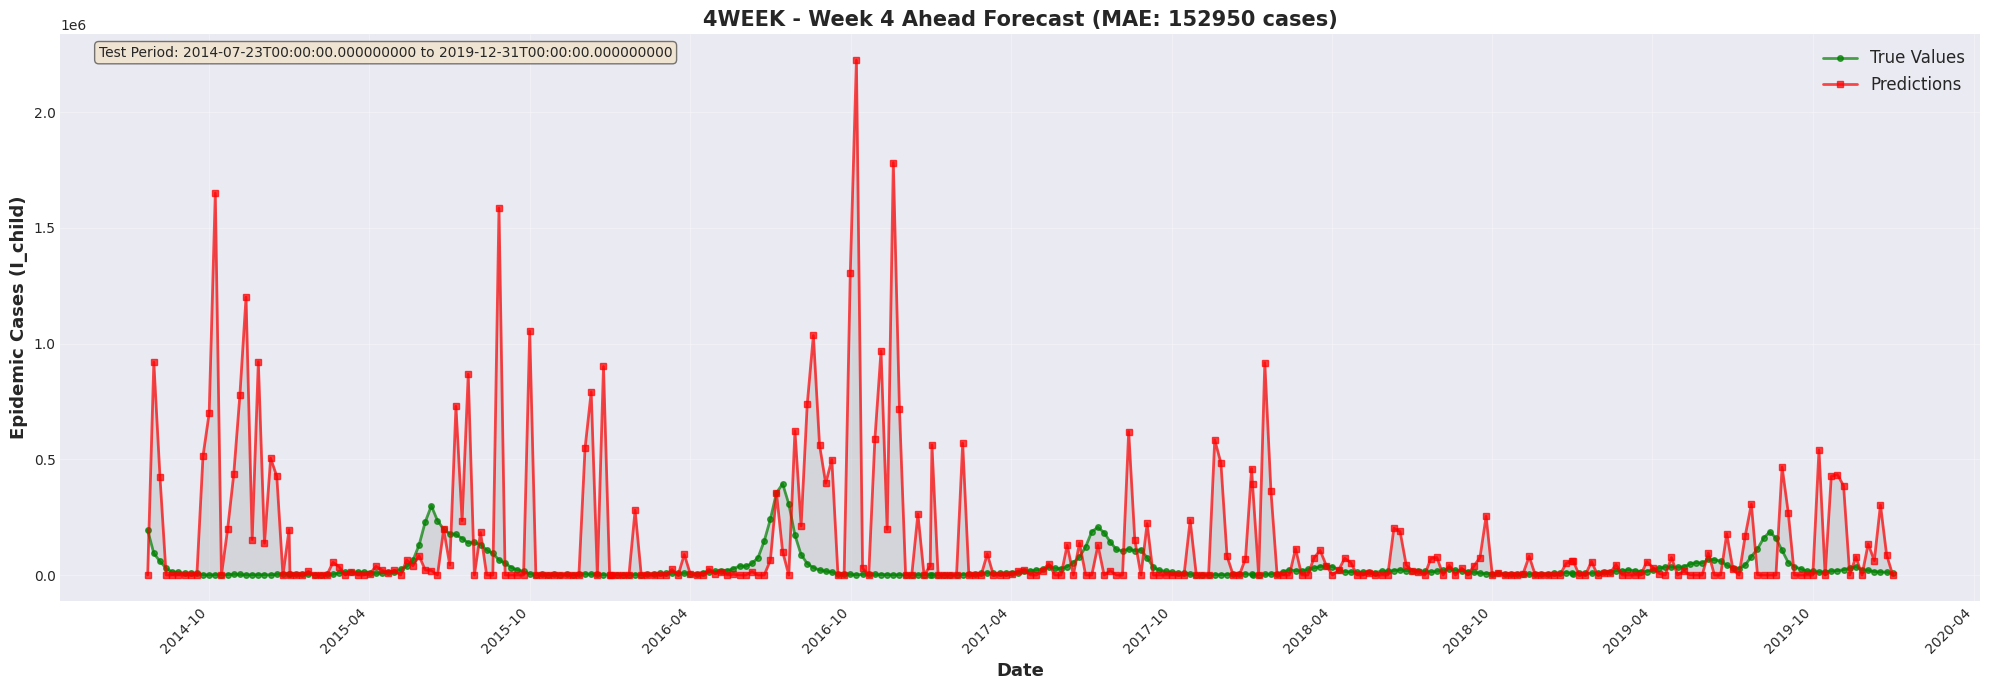

4week - Week 4: Forecast period from 2014-07-23T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 289
  MAE: 152950 cases
  Mean true value: 35489 cases



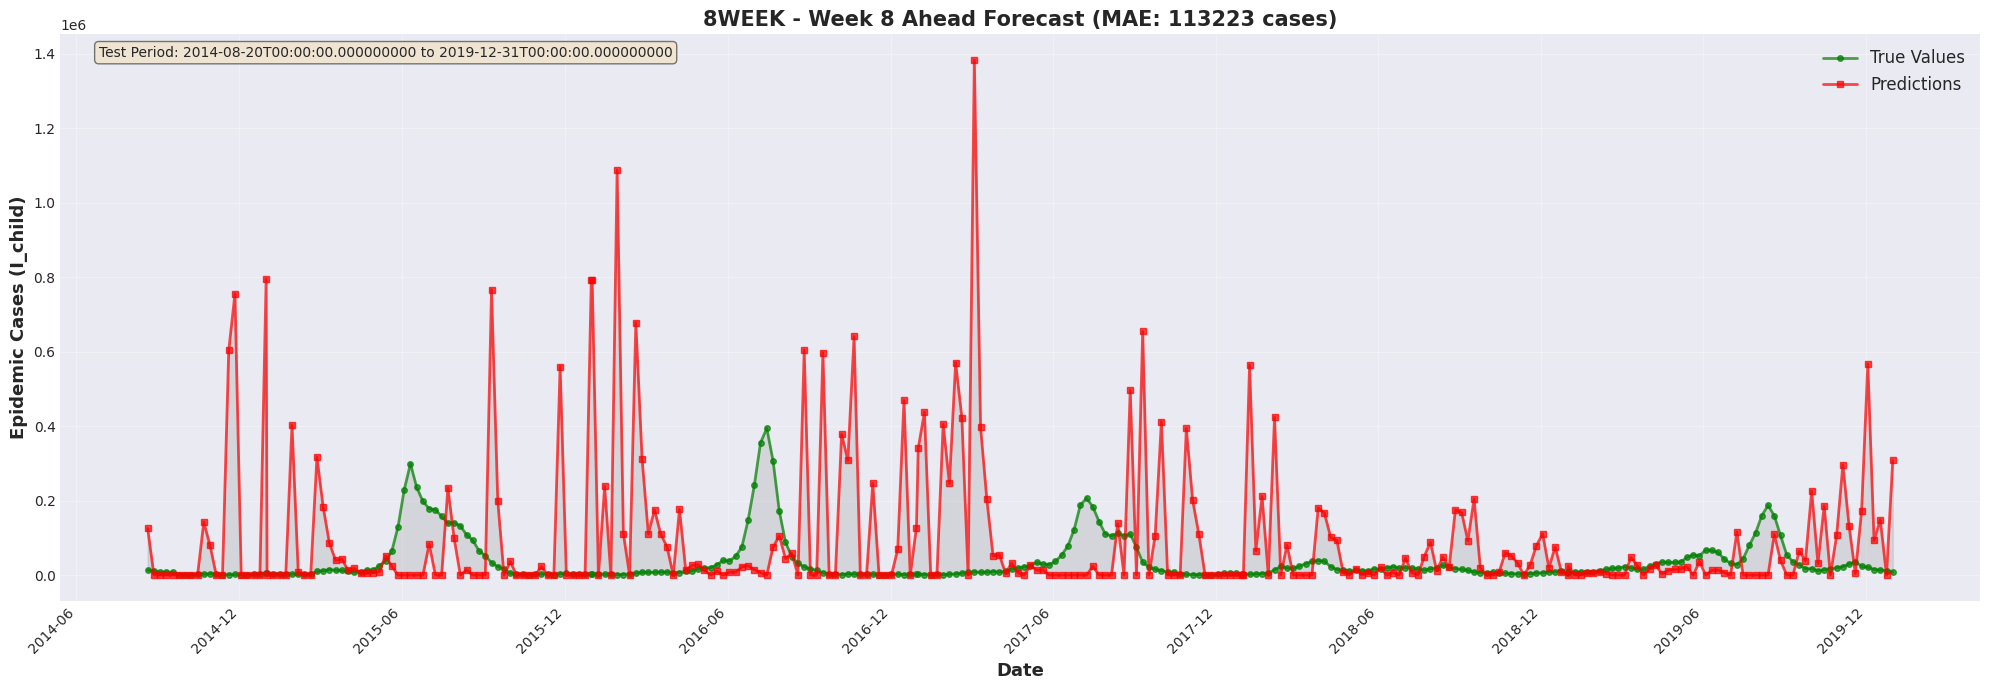

8week - Week 8: Forecast period from 2014-08-20T00:00:00.000000000 to 2019-12-31T00:00:00.000000000
  Number of forecasts: 285
  MAE: 113223 cases
  Mean true value: 34666 cases



In [16]:
# ============================================================================
# CELL 7: Time Series View with Actual Dates - Full Test Set
# ============================================================================

def plot_full_timeseries_with_dates(horizon, week_idx=0):
    """Plot full test set predictions for specific week ahead with actual dates"""
    
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    # Handle 1D arrays
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
        trues = trues.reshape(-1, 1)
    
    # Load original data to get dates
    df_raw = pd.read_csv('./epidemics_30years_full.csv')
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    
    # Calculate test set indices (last 10% of data)
    # Based on 70/20/10 train/val/test split
    total_len = len(df_raw)
    num_test = int(total_len * 0.2)  # Test is last 20% actually
    test_start_idx = total_len - num_test
    
    # Get test dates - need to account for sequence length and prediction length
    # Each prediction corresponds to a date in the test set
    seq_len = 26  # From your training config
    pred_len = int(horizon.replace('week', ''))
    
    # Test dates start from test_start_idx
    # But we need seq_len history, so actual forecast dates start later
    forecast_start_idx = test_start_idx + seq_len + week_idx
    
    # Get dates for the test predictions
    num_samples = len(preds)
    test_dates = df_raw['date'].iloc[forecast_start_idx:forecast_start_idx + num_samples].values
    
    # Select specific week ahead
    pred_week = preds[:, week_idx]
    true_week = trues[:, week_idx]
    
    # Truncate to match available dates
    min_len = min(len(test_dates), len(pred_week))
    test_dates = test_dates[:min_len]
    pred_week = pred_week[:min_len]
    true_week = true_week[:min_len]
    
    fig, ax = plt.subplots(figsize=(20, 7))
    
    ax.plot(test_dates, true_week, 'o-', color='green', linewidth=2, 
            markersize=4, label='True Values', alpha=0.7)
    ax.plot(test_dates, pred_week, 's-', color='red', linewidth=2, 
            markersize=4, label='Predictions', alpha=0.7)
    
    ax.fill_between(test_dates, pred_week, true_week, alpha=0.2, color='gray')
    
    mae = np.mean(np.abs(pred_week - true_week))
    
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.set_ylabel('Epidemic Cases (I_child)', fontsize=13, fontweight='bold')
    ax.set_title(f'{horizon.upper()} - Week {week_idx+1} Ahead Forecast (MAE: {mae:.0f} cases)', 
                 fontsize=15, fontweight='bold')
    ax.legend(loc='best', fontsize=12)
    ax.grid(alpha=0.3)
    
    # Format x-axis dates
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Every 6 months
    plt.xticks(rotation=45, ha='right')
    
    # Add date range info
    date_range = f"{test_dates[0]} to {test_dates[-1]}"
    ax.text(0.02, 0.98, f'Test Period: {date_range}', 
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(f'timeseries_dated_{horizon}_week{week_idx+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"{horizon} - Week {week_idx+1}: Forecast period from {test_dates[0]} to {test_dates[-1]}")
    print(f"  Number of forecasts: {len(pred_week)}")
    print(f"  MAE: {mae:.0f} cases")
    print(f"  Mean true value: {true_week.mean():.0f} cases")
    print()

# Plot week 1 ahead for all horizons with dates
for horizon in horizons:
    plot_full_timeseries_with_dates(horizon, week_idx=0)

# Optional: Plot last week for multi-week horizons
print("\n" + "="*80)
print("LAST WEEK FORECASTS (showing final week ahead for each horizon)")
print("="*80)
for horizon in ['2week', '4week', '8week']:
    pred_len = int(horizon.replace('week', ''))
    plot_full_timeseries_with_dates(horizon, week_idx=pred_len-1)


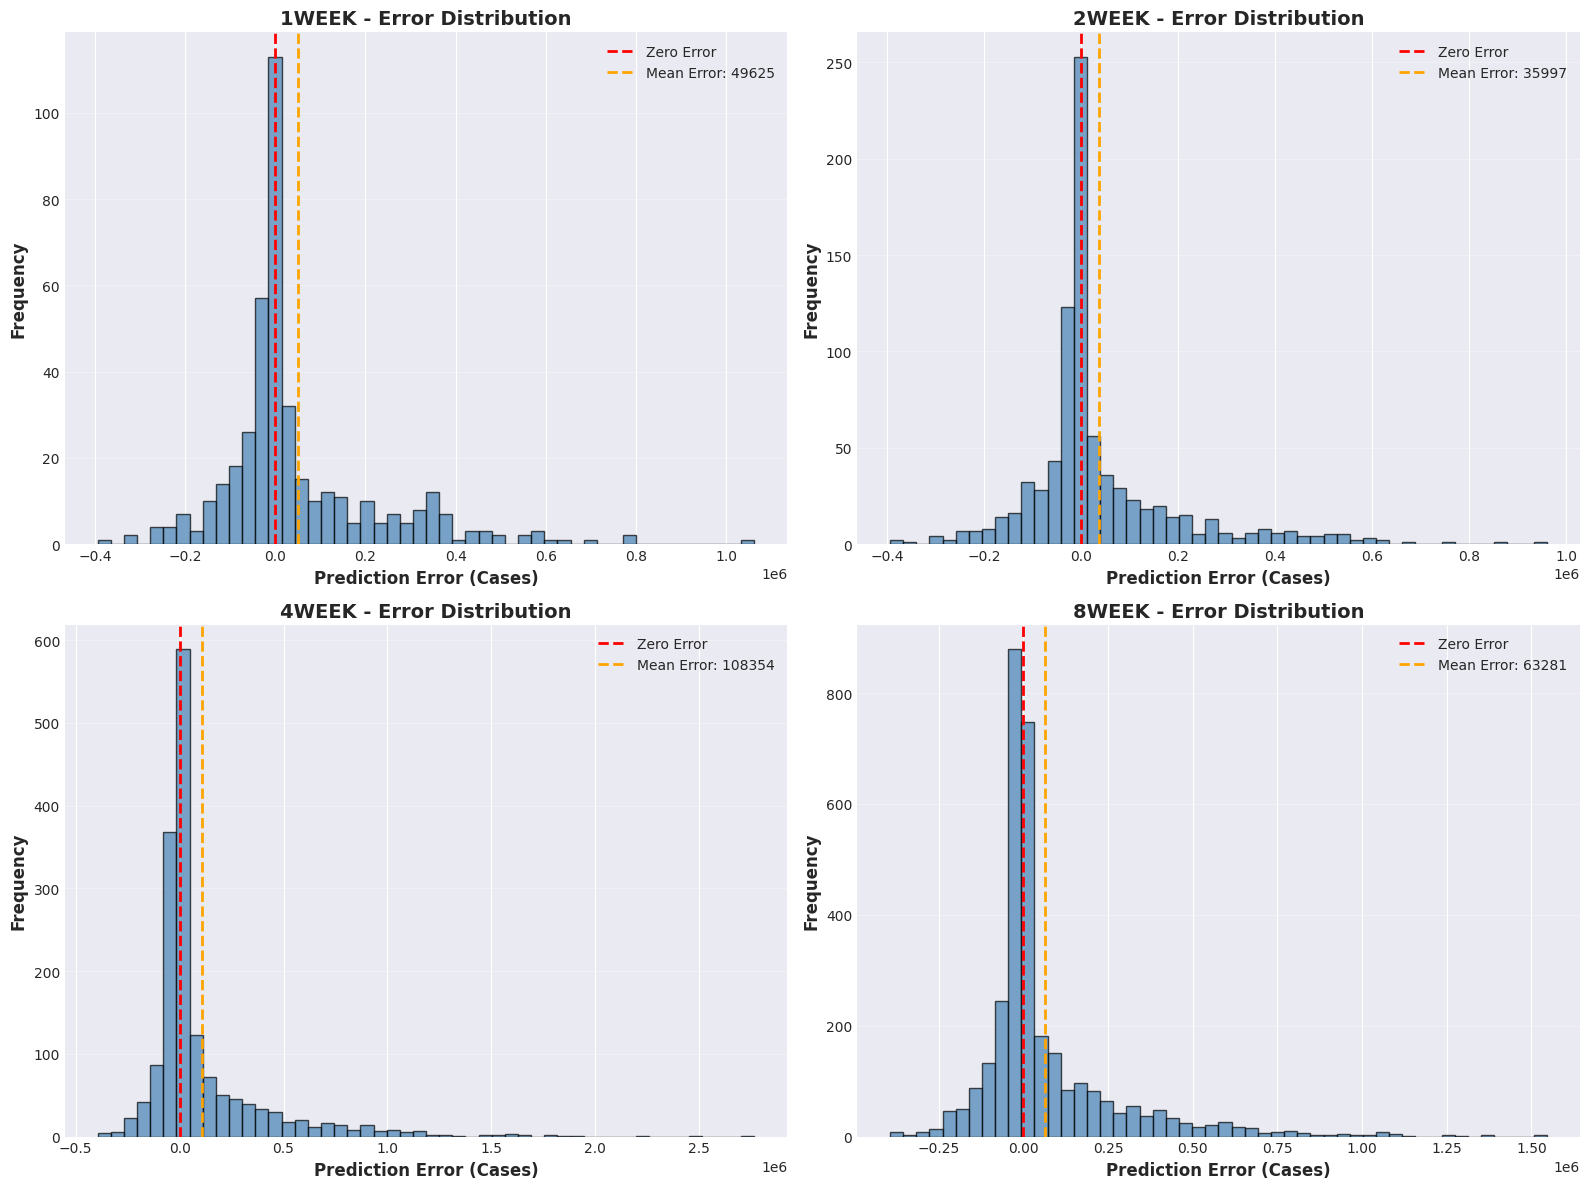

In [9]:
# ============================================================================
# CELL 8: Error Distribution Analysis
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, horizon in enumerate(horizons):
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    # Flatten all predictions and errors
    errors = (preds - trues).flatten()
    
    ax = axes[idx]
    
    # Histogram
    ax.hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(errors.mean(), color='orange', linestyle='--', linewidth=2, 
               label=f'Mean Error: {errors.mean():.0f}')
    
    ax.set_xlabel('Prediction Error (Cases)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon.upper()} - Error Distribution', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

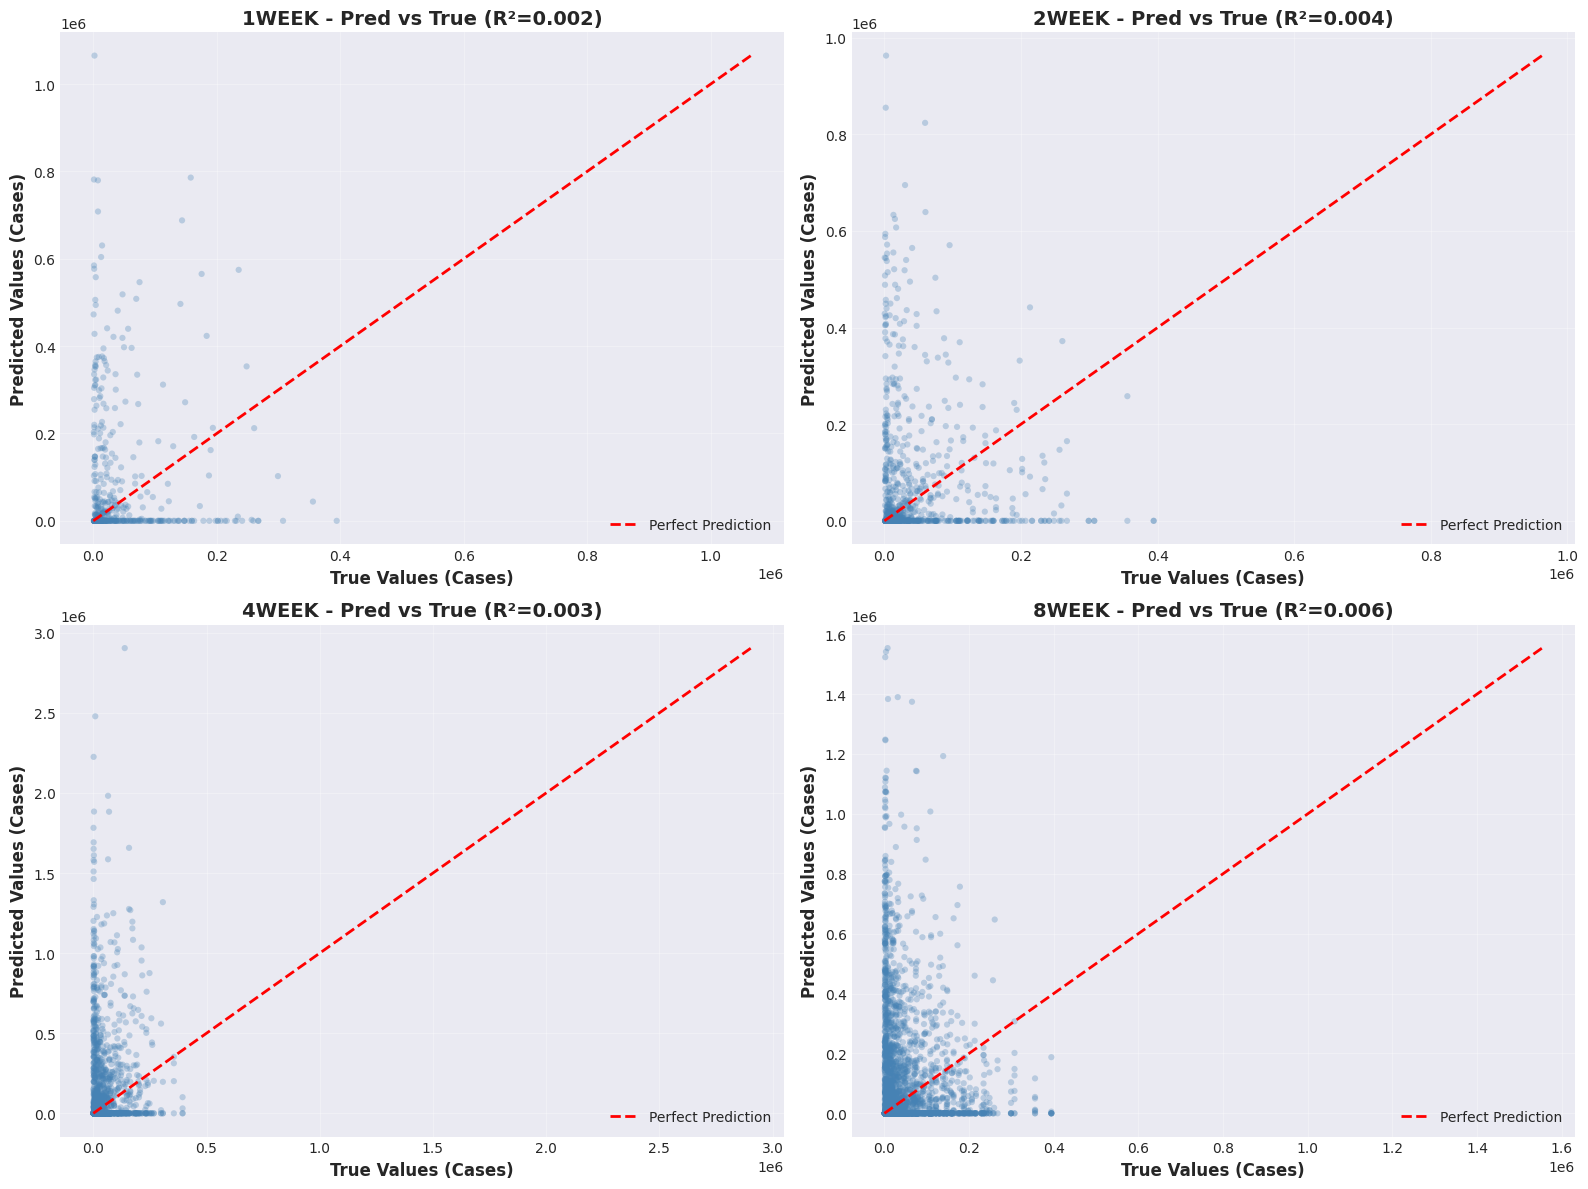

In [10]:
# ============================================================================
# CELL 9: Scatter Plot - Predictions vs True Values
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, horizon in enumerate(horizons):
    preds = all_results[horizon]['preds'].flatten()
    trues = all_results[horizon]['trues'].flatten()
    
    ax = axes[idx]
    
    # Scatter
    ax.scatter(trues, preds, alpha=0.3, s=20, color='steelblue', edgecolor='none')
    
    # Perfect prediction line
    min_val = min(trues.min(), preds.min())
    max_val = max(trues.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
            label='Perfect Prediction')
    
    # Compute R²
    correlation = np.corrcoef(trues, preds)[0, 1]
    r2 = correlation ** 2
    
    ax.set_xlabel('True Values (Cases)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Values (Cases)', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon.upper()} - Pred vs True (R²={r2:.3f})', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_pred_vs_true.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# ============================================================================
# CELL 10: Comparative Performance Summary
# ============================================================================

# Create comprehensive comparison
comparison_data = []

for horizon in horizons:
    preds = all_results[horizon]['preds']
    trues = all_results[horizon]['trues']
    
    # Handle 1D arrays
    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)
        trues = trues.reshape(-1, 1)
    
    overall = compute_metrics(preds, trues)
    
    # Per-week metrics
    num_weeks = preds.shape[1]
    weekly_maes = []
    for week in range(num_weeks):
        mae = np.mean(np.abs(preds[:, week] - trues[:, week]))
        weekly_maes.append(mae)
    
    comparison_data.append({
        'Horizon': horizon,
        'Overall MAE': overall['MAE'],
        'Overall RMSE': overall['RMSE'],
        'Week 1 MAE': weekly_maes[0] if len(weekly_maes) > 0 else None,
        'Last Week MAE': weekly_maes[-1] if len(weekly_maes) > 0 else None,
        'Mean True': trues.mean(),
        'MAE / Mean': overall['MAE'] / trues.mean()
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)
print(f"\nBest Overall: {df_comparison.loc[df_comparison['Overall MAE'].idxmin(), 'Horizon']}")
print(f"Best Week 1: {df_comparison.loc[df_comparison['Week 1 MAE'].idxmin(), 'Horizon']}")



COMPREHENSIVE PERFORMANCE COMPARISON
Horizon   Overall MAE  Overall RMSE    Week 1 MAE  Last Week MAE    Mean True  MAE / Mean
  1week 112416.210938 186700.093750 112416.210938  112416.210938 47697.867188    2.356839
  2week  94604.125000 162501.750000 104038.679688   85169.585938 47179.281250    2.005205
  4week 157903.171875 322786.062500 167497.781250  159471.859375 46160.414062    3.420749
  8week 118391.062500 219003.453125 110580.015625  124484.359375 44771.796875    2.644322

Best Overall: 2week
Best Week 1: 2week


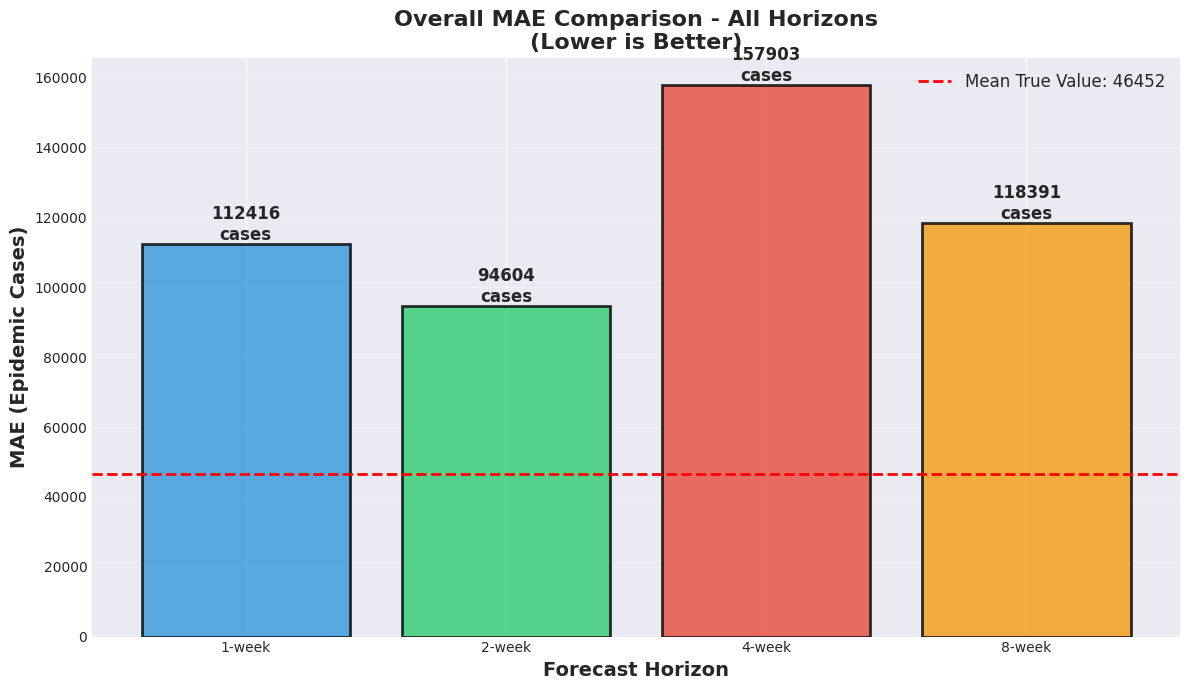


ANALYSIS COMPLETE!

All plots saved:
  - per_week_mae.png
  - forecast_samples_*.png (4 files)
  - timeseries_*.png (4 files)
  - error_distribution.png
  - scatter_pred_vs_true.png
  - overall_mae_comparison.png


In [14]:
# ============================================================================
# CELL 11: Final Summary Plot - All Horizons MAE Comparison
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

horizons_labels = ['1-week', '2-week', '4-week', '8-week']
overall_maes = [df_comparison.loc[df_comparison['Horizon'] == h.replace('-', ''), 'Overall MAE'].values[0] 
                for h in horizons]

bars = ax.bar(horizons_labels, overall_maes, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], 
              alpha=0.8, edgecolor='black', linewidth=2)

# Add values on bars
for i, (bar, mae) in enumerate(zip(bars, overall_maes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.0f}\ncases',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('MAE (Epidemic Cases)', fontsize=14, fontweight='bold')
ax.set_xlabel('Forecast Horizon', fontsize=14, fontweight='bold')
ax.set_title('Overall MAE Comparison - All Horizons\n(Lower is Better)', 
             fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add mean reference line
mean_true = df_comparison['Mean True'].mean()
ax.axhline(mean_true, color='red', linestyle='--', linewidth=2, 
           label=f'Mean True Value: {mean_true:.0f}')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('overall_mae_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nAll plots saved:")
print("  - per_week_mae.png")
print("  - forecast_samples_*.png (4 files)")
print("  - timeseries_*.png (4 files)")
print("  - error_distribution.png")
print("  - scatter_pred_vs_true.png")
print("  - overall_mae_comparison.png")

